# Predict TripAdvisor Rating

В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
По ходу задачи:

Прокачаем работу с pandas
Научимся работать с Kaggle Notebooks
Поймем как делать предобработку различных данных
Научимся работать с пропущенными данными (Nan)
Познакомимся с различными видами кодирования признаков
Немного попробуем Feature Engineering (генерировать новые признаки)
И совсем немного затронем ML
И многое другое...
И самое важное, все это вы сможете сделать самостоятельно!
Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!
Вы можете использовать его как основу для построения своего решения.

что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.
baseline создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь)

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат. Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# Import

In [1]:
import os
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm as progress
from googlemaps import Client as GoogleMaps
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
from itertools import combinations
import geocoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)  # Show more rows
pd.set_option('display.max_columns', 50)  # Show more columns

np.set_printoptions(suppress=True)

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Data

In [5]:
data_dir = os.getcwd() + '/kaggle/input/sf-dst-restaurant-rating/'
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\user\Garri_Folder\module_3\TripAdvisor/kaggle/input/sf-dst-restaurant-rating/distance.scv
C:\Users\user\Garri_Folder\module_3\TripAdvisor/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
C:\Users\user\Garri_Folder\module_3\TripAdvisor/kaggle/input/sf-dst-restaurant-rating/main_task.csv
C:\Users\user\Garri_Folder\module_3\TripAdvisor/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [6]:
df_train = pd.read_csv(data_dir+'/main_task.csv')
df_test = pd.read_csv(data_dir+'/kaggle_task.csv')
sample_submission = pd.read_csv(data_dir+'/sample_submission.csv')

## Анализ количественные характеристик

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_train.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [10]:
df_test.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638


In [11]:
sample_submission.head(3)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

In [14]:
data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [15]:
# Получение списка признаков
data.columns.tolist()

['Restaurant_id',
 'City',
 'Cuisine Style',
 'Ranking',
 'Price Range',
 'Number of Reviews',
 'Reviews',
 'URL_TA',
 'ID_TA',
 'sample',
 'Rating']

In [16]:
# Приведем названия признаков в общему виду, для более удобной работы
data.rename(columns=lambda с: с.lower().replace(' ', '_'), inplace=True)

In [17]:
# Просмотр случайного кадра полученного датафрейма
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
14431,id_792,Berlin,"['German', 'Bar', 'European', 'Pub', 'Vegetari...",793.0,$,85.0,"[['Amazing restaurant in Berlin', 'Berlin vibe...",/Restaurant_Review-g187323-d983956-Reviews-Sch...,d983956,1,4.5
8365,id_8365,Paris,NaN,11537.0,NaN,6.0,"[['Oriental Cuisine'], ['05/06/2017']]",/Restaurant_Review-g187147-d12067973-Reviews-R...,d12067973,0,0.0
40468,id_12541,London,NaN,12551.0,NaN,NaN,"[['Very friendly people. Family work'], ['11/1...",/Restaurant_Review-g186338-d5816855-Reviews-Bl...,d5816855,1,4.0
22902,id_6312,Berlin,NaN,6314.0,NaN,4.0,"[[], []]",/Restaurant_Review-g187323-d8732455-Reviews-Ba...,d8732455,1,2.0
36099,id_3755,Rome,['Italian'],3756.0,$,29.0,"[['Great place for a panini', 'Exquisite Deli ...",/Restaurant_Review-g187791-d4232416-Reviews-Fr...,d4232416,1,4.5


# Cleaning and Preparing Data

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [19]:
# Посмотрим на уникальность данных
data.nunique()

restaurant_id        13094
city                    31
cuisine_style        10731
ranking              12975
price_range              3
number_of_reviews     1573
reviews              41857
url_ta               49963
id_ta                49963
sample                   2
rating                  10
dtype: int64

Как видно, такие признаки как `Restaurant_id`, `URL_TA`, `ID_TA`, которые якобы должны быть уникальными, имеют дубли.  
Возможные причины:  
- ошибки в данных, например, если датасет собирался из разных источников.
- ресторан является сетевым и под одним id находится несколько ресторанов в разных локациях.

Вывод: большинство признаков у нас требует очистки и предварительной обработки.

# Обработка пропусков

In [20]:
data.isna().sum()

restaurant_id            0
city                     0
cuisine_style        11590
ranking                  0
price_range          17361
number_of_reviews     3200
reviews                  2
url_ta                   0
id_ta                    0
sample                   0
rating                   0
dtype: int64

restaurant_id - 0.0%
city - 0.0%
cuisine_style - 23.0%
ranking - 0.0%
price_range - 35.0%
number_of_reviews - 6.0%
reviews - 0.0%
url_ta - 0.0%
id_ta - 0.0%
sample - 0.0%
rating - 0.0%


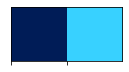

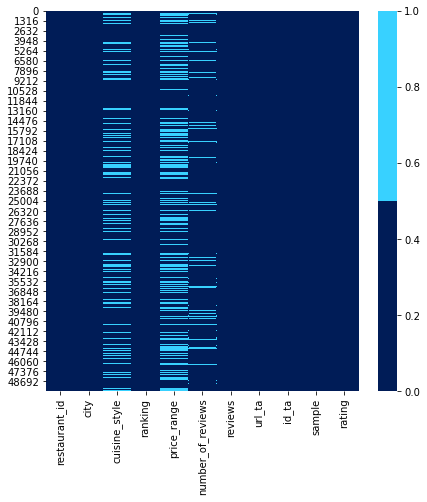

In [21]:
colors = ['#001c57', '#38d1ff']

cols = data.columns
sns.palplot(sns.color_palette(colors))

fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colors))

# Отображение распределения пропусков
for col in cols:
    pct_missing = np.mean(data[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

Признаки cuisine_style, price_range, number_of_reviews потребуют работы с пропусками данных

### Признак restoran_id

In [22]:
# Выявление сетевых ресторанов, формирование признака сетевого ресторана в отдельном признаке chain

data.restaurant_id.value_counts()

id_871      19
id_227      19
id_633      19
id_436      19
id_71       18
            ..
id_10074     1
id_11374     1
id_9826      1
id_10861     1
id_11759     1
Name: restaurant_id, Length: 13094, dtype: int64

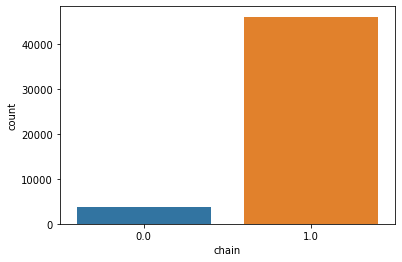

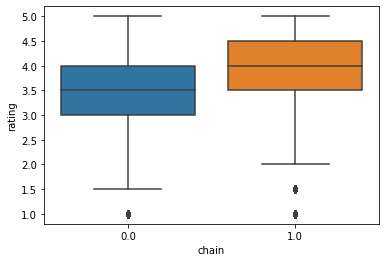

In [23]:
# Формирование признака сетевого ресторана chain с заполнением данными
chain_lst = list(data.restaurant_id.value_counts()[data.restaurant_id.value_counts() > 1].index)
data['chain'] = data[data.restaurant_id.isin(chain_lst)].restaurant_id.apply(lambda x: 1)
data['chain'].fillna(0, inplace=True)

fig, ax = plt.subplots()
sns.countplot(data['chain'], ax=ax)
plt.show()

fig, ax = plt.subplots()
sns.boxplot(x='chain', y='rating', data=data[data['sample'] != 0])
plt.show()

Сетевые рестораны имеют больший средний рейтинг и более высокий его диапазон по сравнению с несетевыми

### Признак **number_of_reviews**

In [24]:
# Заполним пропуски средним значением по городу.
# Для этого посчитаем среднее значение кол-во отзывов по городам

fill_values = round(data.groupby('city')['number_of_reviews'].mean(), 0)
data.number_of_reviews = data.apply(lambda row: fill_values[row['city']] if pd.isna(row['number_of_reviews'])
                                    else row['number_of_reviews'], axis=1)

### Признак **price_range**

In [25]:
# Анализ распределения значений признака price_range
data.price_range.value_counts(ascending=False)

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [26]:
# # Изменим значения ценовых категорий на числовые значения 1, 10, 100 - по аналогии с функцией LabelEncoding
# data.price_range.replace(['$', '$$ - $$$', '$$$$'], [10, 100, 1000], inplace=True)

In [27]:
# Изменим значения ценовых категорий на числовые значения 1, 10, 100 - по аналогии с функцией LabelEncoding
data.price_range.replace(['$', '$$ - $$$', '$$$$'], ['1', '2', '3'], inplace=True)

In [28]:
# # Заполним пропуски price_range медианными значением по каждому отдельному городу.

# fill_values = data.groupby('city')['price_range'].median()
# data.price_range = data.apply(lambda row: fill_values[row['city']] if pd.isna(row['price_range'])
#                               else row['price_range'], axis=1)

In [29]:
# Заполним пропуски price_range медианными значением по каждому отдельному городу.

data.price_range = data.price_range.fillna('1')

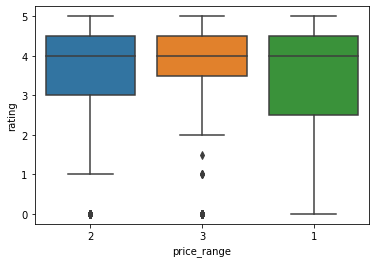

In [30]:
fig, ax = plt.subplots()
sns.boxplot(x='price_range', y='rating', data=data)
plt.show()

### Создание признака столицы

In [31]:
# Создадим признак capital_city если город является столицей

capitals = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague', 'Lisbon',
        'Vienna', 'Amsterdam', 'Brussels', 'Stockholm', 'Budapest', 'Warsaw',
        'Dublin', 'Copenhagen', 'Athens', 'Oslo', 'Helsinki', 'Bratislava',
        'Luxembourg', 'Ljubljana', 'Edinburgh'
    ]

data['is_capital_city'] = data['city'].apply(lambda x: 1 if x in capitals else 0)

In [32]:
# a new feature "Country Code"

city_country = {
    'London': 'UK',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugalia',
    'Vienna': 'Austria',
    'Amsterdam': 'Nederlands',
    'Brussels': 'EU',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Hungary',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland',
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Schotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugalia',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenija'
}

data['country_code'] = data['city'].map(city_country)

le = LabelEncoder()
le.fit(data['country_code'])
data['country_code'] = le.transform(data['country_code'])

### Добавим новый признак численности населения города

In [33]:
# Создаем признак численности населения города

population = {
    'Paris': 2190327,
    'Stockholm': 961609,
    'London': 8908081,
    'Berlin': 3644826,
    'Munich': 1456039,
    'Oporto': 237591,
    'Milan': 1378689,
    'Bratislava': 432864,
    'Vienna': 1821582,
    'Rome': 4355725,
    'Barcelona': 1620343,
    'Madrid': 3223334,
    'Dublin': 1173179,
    'Brussels': 179277,
    'Zurich': 428737,
    'Warsaw': 1758143,
    'Budapest': 1752286,
    'Copenhagen': 615993,
    'Amsterdam': 857713,
    'Lyon': 506615,
    'Hamburg': 1841179,
    'Lisbon': 505526,
    'Prague': 1301132,
    'Oslo': 673469,
    'Helsinki': 643272,
    'Edinburgh': 488100,
    'Geneva': 200548,
    'Ljubljana': 284355,
    'Athens': 664046,
    'Luxembourg': 115227,
    'Krakow': 769498
}

# Создадим количественный признак численности населения
data['population'] = data['city'].map(population)

### Парсинг данных с сайта  

Получение информации с сайта ресторана о географических координатах его расположения и формирование признака 
расстояния от ресторана до центра города

В комментариях приведен код, с помощью которого была получена геолокация ресторанов датафрейма

In [34]:
# Формирование класса обработки данных с сайта tripadvisor
# Включает как получение географических данных с помощью geocoder 
# при невозможности проводится парсинг данных адресса ресторана и получение его координат с помощью geocoder

#from math import radians, sin, cos, asin, sqrt

#gmaps = GoogleMaps('XXXXxxxxxxxxxxxXXXXXXxxxxxxxxxxxxxXXXX')


#class restaurant_parser():

#    def pars_address(self):

#        self._response = requests.get(self._base_url)
#        self._soup = BeautifulSoup(self._response.text, 'lxml')
#        self._address = self._soup.find('a', {'href': "#MAPVIEW", 'class': '_15QfMZ2L'})
#        if self._address:
#             self._address = self._address.text
#         else:
#             self._address = ''

#     def get_address(self):
#         return self._address
    
#     def get_latlng(self, _address, _inplace = False):

#         _geocode = []
#         _lat = 0
#         _lng = 0
        
#         if _address == '':
#             if _inplace:
#                 self._geocode, self._lat, self._lng = _geocode, _lat, _lng
#             return _geocode, _lat, _lng
            
#         _geocode = gmaps.geocode(_address)
#         if _geocode:
#             _lat = _geocode[0]['geometry']['location']['lat']
#             _lng = _geocode[0]['geometry']['location']['lng']
#         if _inplace:
#             self._geocode, self._lat, self._lng = _geocode, _lat, _lng
#         return _geocode, _lat, _lng
        
#     def get_geocode(self):
        
#         self.get_latlng(self._base_url, True)
#         if not self._geocode:
#             self.pars_address()
#             self.get_latlng(self._address, True)        
        
#     def __init__(self, _url):

#         self._base_url = 'https://www.tripadvisor.com' + _url
            
#     def get_distance(self, _city):

#         if self._lng == 0 and self._lat == 0:
#             return 9999
        
#         _, _lat, _lng = self.get_latlng(_city + ', ' + city_country[_city])
#         if _lng == 0 and _lat == 0:
#             return 9999
        
#         lon1, lat1, lon2, lat2 = map(
#             radians, [self._lng, self._lat, _lng, _lat])
#         dlon = lon2 - lon1
#         dlat = lat2 - lat1
#         a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
#         c = 2 * asin(sqrt(a))
#         earth_radius = 6371

#         return c * earth_radius

In [35]:
# def parsing_location_geocode(row):
    
#     try:
#         html_page = restaurant_parser(row['url_ta'])
#         html_page.get_geocode()
#         row['distance_downtown'] = html_page.get_distance(row['city'])
#         if row['distance_downtown'] == 0:
#             html_page.pars_address()
#             html_page.get_latlng(html_page.get_address(), True)  
#             row['distance_downtown'] = html_page.get_distance(row['city'])
            
#     except Exception:
#         row['distance_downtown'] = 9999
#     else:
#         if row['distance_downtown'] > 100:
#             row['distance_downtown'] = 9999            
#     finally:
#         return row

In [36]:
# Обработка ссылок на сайте ресторанов

#data['distance_downtown'] = 0
#data = data.apply(parsing_location_geocode, axis = 1)

In [37]:
# Сохранение данных в файле для дальнейшего использования в кагле
# data.to_csv(data_dir + '/distance.scv', columns = ['restaurant_id', 'city', 'distance_downtown'])

In [38]:
data_distance = pd.read_csv(data_dir+'/distance.scv')

In [39]:
data['distance_downtown'] = data_distance['distance_downtown']

### Признак **reviews**

In [40]:
data.reviews.value_counts()

[[], []]                                                                                               8112
[['The real codido madrileño'], ['03/31/2017']]                                                           2
[['Sat night', 'Can\'t even explain.. "A" place.. A "100...'], ['10/22/2017', '05/11/2017']]              2
[['ok for beer, not for dinner'], ['12/20/2017']]                                                         2
[['Enjoyable restaurant with indoor and outdo...', 'Delicious food'], ['11/04/2017', '10/31/2017']]       2
                                                                                                       ... 
[['Excellent food', 'Tasty middle eastern food'], ['01/06/2018', '12/22/2017']]                           1
[['Amazing kebab!', 'Needs to remember it was good'], ['10/11/2017', '09/02/2016']]                       1
[['Most Memorable Meal in Rome', 'Excellent!!'], ['06/02/2017', '12/22/2016']]                            1
[['Pleasant Small Coffee Sho

Видно, что 8112 строк в признаке reviews имеют пустое значение `[[], []]`
Не будем менять это значение, потому что предполагаем трансформировать этот признак в два числовых. Значение NaN заполним пустой строкой

In [41]:
data['reviews'].fillna('', inplace = True)

#### Анализ степени эмоциональности и формирование признака из совокупности дат отзывов

In [42]:
# Списки слов для оценки степени эмоциональности отзыва

_well = sorted(['affect', 'agitat', 'amaz', 'amit', 'astir', 'astonish', 'attachment', 'attentive', 'attract', 'awe',
                'best', 'calm', 'care', 'charm', 'cheap','cheerful', 'cheerless', 'clean', 'concentrat', 'confiden', 'cool',
                'delicious', 'desire', 'disciplin', 'elat', 'enjoy', 'excellent', 'excit', 'fabulous', 'fantastic',
                'fascinat', 'fresh', 'friendly', 'glad', 'good', 'gorgeous', 'great', 'lovely', 'happy', 'hilarious',
                'honest', 'joy', 'like', 'love', 'magnificent', 'merri', 'nice', 'ok', 'okay', 'outstand', 'proud',
                'quiet', 'rigth', 'sincer', 'stunn', 'tasty', 'terrific', 'thrilling', 'touching', 'unique'
                ])

_bad = sorted(['afraid', 'aggress', 'anger', 'angry', 'annoy', 'antipath', 'anxiet', 'anxious', 'arrogant',
               'avers', 'awful', 'bodacious', 'bored', 'busy', 'confusion', 'contempt', 'contemptuous', 'depress',
               'depressed', 'despair', 'despondent', 'dirty', 'disappoint', 'disgrac', 'disgust', 'disillusion', 'dislike',
               'doleful', 'dreadful', 'dull', 'embarrass', 'enmity', 'fear', 'fright', 'frustrat', 'furious', 'grief',
               'guilt', 'gloomy', 'haught', 'horror', 'hostilit', 'humiliat', 'indifference', 'insane', 'irritat', 'lazy', 'mad',
               'miserable', 'mourn', 'nervous', 'outrageous', 'regret', 'remorse', 'sad', 'sad', 'satisfaction', 'scare',
               'shame', 'shocked', 'sorrow', 'tense', 'terrible', 'unhappy', 'upset', 'worried', 'worst', 'expens'
               ])

In [43]:
# Функция сравнения двух подстрок слов
def compare_str(_fw, _sw):

    _len = min(len(_fw), len(_sw))
    if (_fw[0:_len-1] == _sw[0:_len-1]):
        return True
    else:
        return False

In [44]:
# Функция поиска подстроки в списке слов-патернов эмоций, путем реализации скоростного бинарного поиска
# по сортированному списку

def find_in_list(_list, _world):

    _low = 0
    _high = len(_list) - 1
    _len = len(_world)

    # использование среднего числа диапазона для уточнения диапазона поиска
    _pos = (_low + _high)//2

    while not compare_str(_world, _list[_low]) or not compare_str(_world, _list[_high]) or not compare_str(_world, _list[_pos]):
        _w = _list[_pos]
        _c_len = min(len(_w), _len)
        if _world[0:_c_len-1] > _w[0:_c_len-1]:
            _low = _pos + 1
            _high -= 1
        else:
            _low += 1
            _high = _pos - 1
        _pos = (_low + _high)//2
        if _low == _high or _pos <= _low or _pos >= _high or _pos < 0:
            return False
    else:
        return True

In [45]:
# Формирование признака эмоциональности отзыва на соответствие ключевым словам - самый простейший вариант

def _simple_check_emotion(_world):

    if find_in_list(_well, _world):
        return 1
    elif find_in_list(_bad, _world):
        return -1
    else:
        return 0

In [46]:
# Обработка ячейки на предмет формирования признака эмоциональности отзыва

def get_emotion(_sentence):

    _e_rank = 0
    _list_world = _sentence.lower()
    re.sub(r' [!?.:;,"-\'\"]', '', _list_world)
    _list_world = re.findall(r"\w+", _list_world)

    for _world in _list_world:
        _e_rank += _simple_check_emotion(_world)
    if _e_rank ==0:
        return _e_rank
    elif _e_rank >= 0:
        if _e_rank >= 2:
            return 2
        else:
            return 1
    else:
        if _e_rank <= -2:
            return -2
        else:
            return -1

In [47]:
# Построение признака анализа данных по датам

def get_reviews_date(_list_dates):

    _l = len(_list_dates)
    _now = datetime.today()
    if _l == 0:
        return (0, 0)
    elif _l == 1:
        _d = _now - pd.to_datetime(_list_dates[0], format="%m/%d/%Y")
        _d_b = 0
        return (_d.days, 0)
    elif _l == 2:
        _d1 = _now - pd.to_datetime(_list_dates[0], format="%m/%d/%Y")
        _d2 = _now - pd.to_datetime(_list_dates[1], format="%m/%d/%Y")
        _d_b = abs(_d1.days - _d2.days)
        return (round(np.mean([_d1.days, _d2.days]),0), _d_b)
    else:
        return (0, 0)

In [48]:
# Построение признаков путем прохождения по строкам 
def get_reviews_data(row):
    
    _d_n, _d_b, _e = 0, 0 ,0
    
    if row['reviews'] != '' and row['reviews'] != '[[], []]':
        (_d_n, _d_b) = get_reviews_date(re.findall(r"\d\d\/\d\d\/\d\d\d\d",row['reviews']))
        _e = get_emotion(row['reviews'])      
    return pd.Series([_e, _d_n, _d_b])

In [49]:
data[['review_rank', 'days_now', 'days_between_reviews']] = data.apply(get_reviews_data, axis = 1)

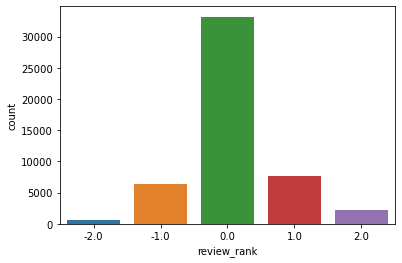

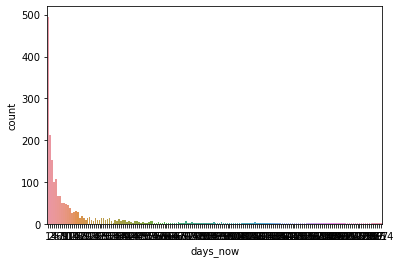

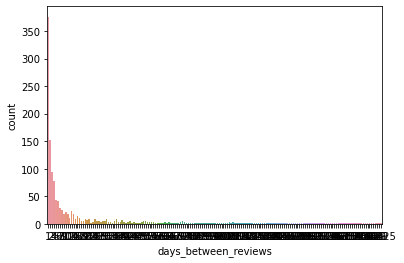

In [50]:
fig, ax = plt.subplots()
sns.countplot(data['review_rank'], ax=ax)
plt.show()

fig, ax = plt.subplots()
sns.countplot(data['days_now'].value_counts(), ax=ax)
plt.show()

fig, ax = plt.subplots()
sns.countplot(data['days_between_reviews'].value_counts(), ax=ax)
plt.show()

### Создадим признак **restaurants_count** - кол-во ресторанов в городе

In [51]:
# Формируем значения признака с указанием количества ресторанов для каждого города, присутствующего в датасете

_dict = dict(data['city'].value_counts())
data['restaurants_count'] = data['city'].map(_dict)

### Создадим признак **ranking_proportion** - отношение признака ranking и restaurants_count

In [52]:
# Города различаются по масштабам ресторанного бизнеса, приводим значение ранга в пропорции к масштабу
# нормализуем признак ranking по городам

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

data['ranking_proportion'] = data['ranking'] / data['restaurants_count']

for city in list(data['city'].unique()):
    scaler = MinMaxScaler()
#    scaler = StandardScaler()
    data[data['city'] == city]['ranking'] = scaler.fit_transform(
        data[data['city'] == city]['ranking'].values.reshape(-1, 1))
    
data['rests_per_capita'] = data['restaurants_count'] / data['population']

### Признак **cuisine_style**

In [53]:
## Кластеризация и прореживание признака

def cuising_claster(_c):

    if _c in ['Healthy', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']:
        return 'Healthy'
    elif _c in ['Seafood', 'Mediterranean', 'Italian', 'Spanish', 'Greek', 'Croatian', 'Portuguese']:
        return 'Mediterranean'
    elif _c in ['International', 'Fusion', 'Contemporary']:
        return 'Fusion'
    elif _c in ['Gastropub', 'Delicatessen']:
        return 'Gastropub'
    elif _c in ['European', 'French', 'British', 'Central European', 'German', 'Czech', 'Eastern European',
                'Austrian', 'Latin', 'Swiss', 'Danish', 'Swedish', 'Polish', 'Hungarian', 'Scandinavian', 'Dutch',
                'Belgian', 'Norwegian' 'Slovenian']:
        return 'European'
    elif _c in ['American', 'Mexican', 'South American', 'Argentinean', 'Central American', 'Brazilian', 'Peruvian',
                'Venezuelan', 'Colombian', 'Southwestern']:
        return 'American'
    elif _c in ['Pub', 'Bar', 'Irish', 'WineBar', 'BrewPub', 'Scottish']:
        return 'Bar'
    elif _c in ['Steakhouse', 'Barbecue', 'Grill']:
        return 'Steakhouse'
    elif _c in ['Pizza']:
        return 'Pizza'
    elif _c in ['Cafe']:
        return 'Cafe'
    elif _c in ['Diner']:
        return 'Diner'
    elif _c in ['Fast Food', 'Street Food']:
        return 'Fast Food'
    elif _c in ['Soups']:
        return 'Soups'
    elif _c in ['Japanese', 'Sushi']:
        return 'Japanese'
    elif _c in ['Indian', 'Pakistani', 'Bangladeshi', 'Nepali', 'Tibetan']:
        return 'Indian'
    elif _c in ['Asian', 'Central Asian', 'Middle Eastern', 'Halal', 'Turkish', 'Lebanese', 'Arabic', 'Tunisian', 'Egyptian',
                'Persian', 'Uzbek']:
        return 'Asian'
    elif _c in ['Yunnan', 'Xinjiang', 'Fujian', 'Minority Chinese', 'Taiwanese', 'Korean', 'Vietnamese', 'Thai',
                'Chinese', 'Asian', 'Singaporean']:
        return 'East Asian'
    elif _c in ['Israeli', 'Kosher']:
        return 'Israeli'
    elif _c in ['Caribbean', 'Jamaican', 'Cuban']:
        return 'Caribbean'
    elif _c in ['African', 'Moroccan', 'Ethiopian']:
        return 'African'
    elif _c in ['Russian', 'Ukrainian', 'Georgian', 'Azerbaijani', 'Caucasian', 'Armenian']:
        return 'Caucasian'
    else:
        return 'Other'

In [54]:
# Создание списка видов кухни
data['cuisine_style'] = data['cuisine_style'].str.findall(r"'(\b.*?\b)'")

In [55]:
# Пропуски в cuisine_style заменим на пустные строки
data['cuisine_style'].fillna('', inplace = True)

###  Создадим признак **cuisine_count** - видов кол-во кухонь в ресторане

In [56]:
# Формирование признака количества кухонь
data['cuisine_count'] = data['cuisine_style'].apply(lambda x: len(x) if len(x) > 1 else 1)

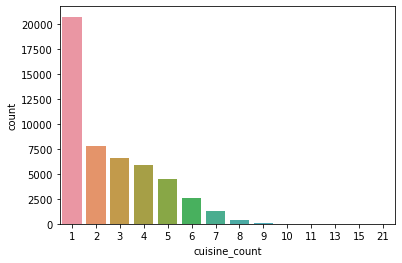

In [57]:
fig, ax = plt.subplots()
sns.countplot(data['cuisine_count'], ax=ax)
plt.show()

### Трансформируем признак видов кухни из списка для проведения кластеризации

In [58]:
# Создание списка колонок расширения датафрейма по типу OHEncoding

_data_test = data[['city', 'cuisine_style']]
_data_test = _data_test.explode('cuisine_style')
_cuisine_style_set = set()

# Присвоение пустому значению cuisine_style наиболее распространенного значения в данном городе

for city in list(data['city'].unique()):

    _city_local  = _data_test[_data_test['city'] == city]['cuisine_style'].value_counts()
    local_style = _city_local.index[0]
    if local_style == '':
        local_style = _city_local.index[1]
    data.update(data[(data['city'] == city) & (data['cuisine_style'] == '')].cuisine_style.replace('', local_style))

_cuisine_style_set.update(_data_test['cuisine_style'])
_cuisine_style_set.discard('')
_s = _cuisine_style_set.copy()
_cuisine_style_set.clear()
for _elem in _s:
    _cuisine_style_set.add(cuising_claster(_elem))
_cuisine_style_set = list(_cuisine_style_set)

In [59]:
def fill_cuisine(_row):

    for _col in _row['cuisine_style']:
        _row['cuisine_' + cuising_claster(_col).lower()] = 1
    return _row

In [60]:
# Формируем категориальные признаки кластеризованных значений видов кухни по типу 

for _col in _cuisine_style_set:
    data['cuisine_' + _col.lower()] = 0
data = data.apply(fill_cuisine, axis=1)

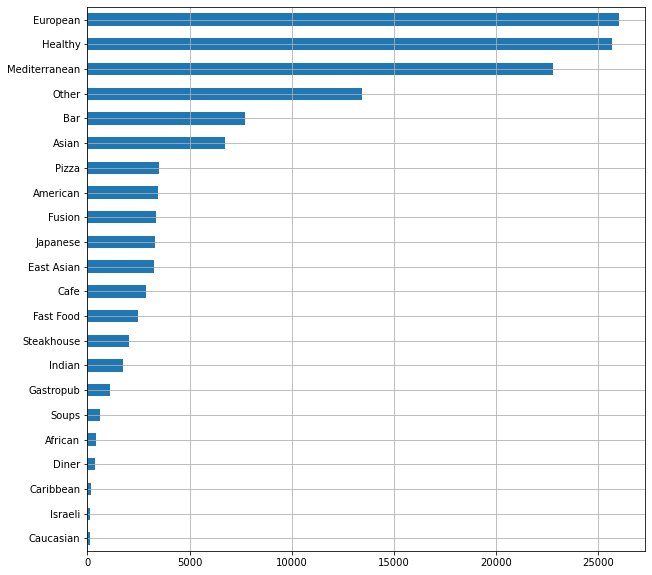

In [61]:
# Список кластеризованных значений признака видов кухонь

cuisine_list = _data_test['cuisine_style'].apply(cuising_claster).value_counts(ascending=True)
plt.figure(figsize=(10,10))
cuisine_list.plot(kind='barh', grid=True)
plt.show()

### Исследуем данные

In [62]:
# # Используем формулу интерквартильной оценки для фильтрации выбросов

# lst_columns = ['number_of_reviews', 'distance_downtown', 'days_now', 'days_between_reviews']

# for _col in lst_columns:
#     median = data[_col].median()
#     IQR = data[_col].quantile(0.75) - data[_col].quantile(0.25)
#     perc25 = data[_col].quantile(0.25)
#     perc75 = data[_col].quantile(0.75)
#     if _col == 'distance_downtown':
#         print(perc75 + 1.5*IQR)
#         data[_col].loc[(data[_col] > 100) | (data[_col] == 0)] = median
#     else:
#         data[_col].loc[data[_col].le(perc25 - 1.5*IQR)] = median
#         data[_col].loc[data[_col].ge(perc75 + 1.5*IQR)] = median


In [63]:
# Используем формулу интерквартильной оценки для фильтрации выбросов

lst_columns = ['number_of_reviews', 'distance_downtown', 'days_now', 'days_between_reviews']

for _col in lst_columns:
    median = data[_col].median()
    IQR = data[_col].quantile(0.75) - data[_col].quantile(0.25)
    perc25 = data[_col].quantile(0.25)
    perc75 = data[_col].quantile(0.75)
    data[_col].loc[data[_col].le(perc25 - 1.5*IQR)] = perc25 - 1.5*IQR
    data[_col].loc[data[_col].ge(perc75 + 1.5*IQR)] = perc75 + 1.5*IQR


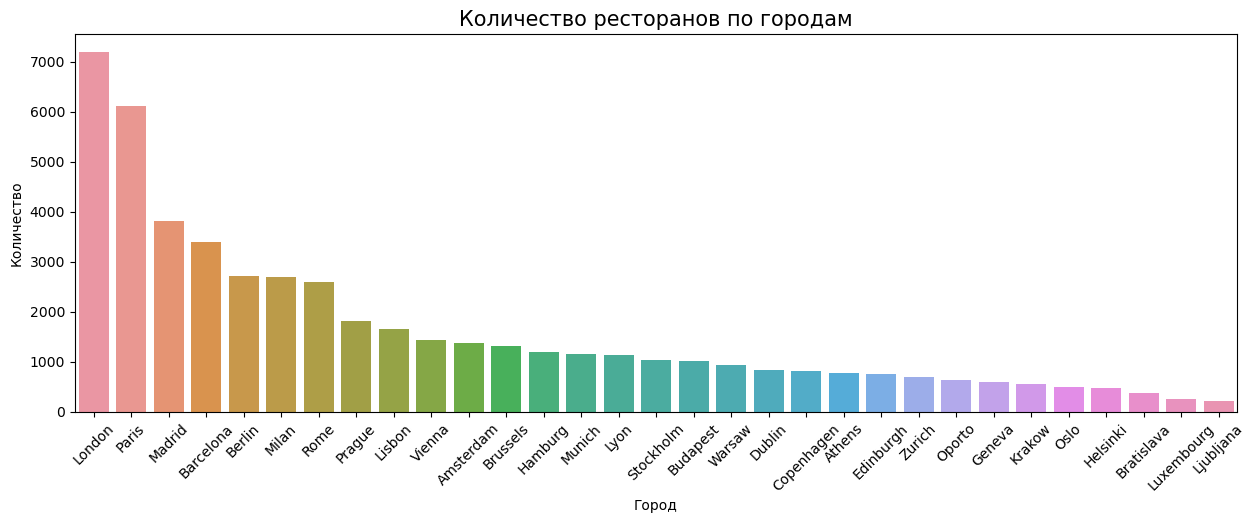

In [64]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(data['city'], order=data['city'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Количество ресторанов по городам', fontsize=15)
plt.xlabel('Город')
plt.ylabel('Количество')
plt.show()

#### Разброс данных определяется масштабом городов

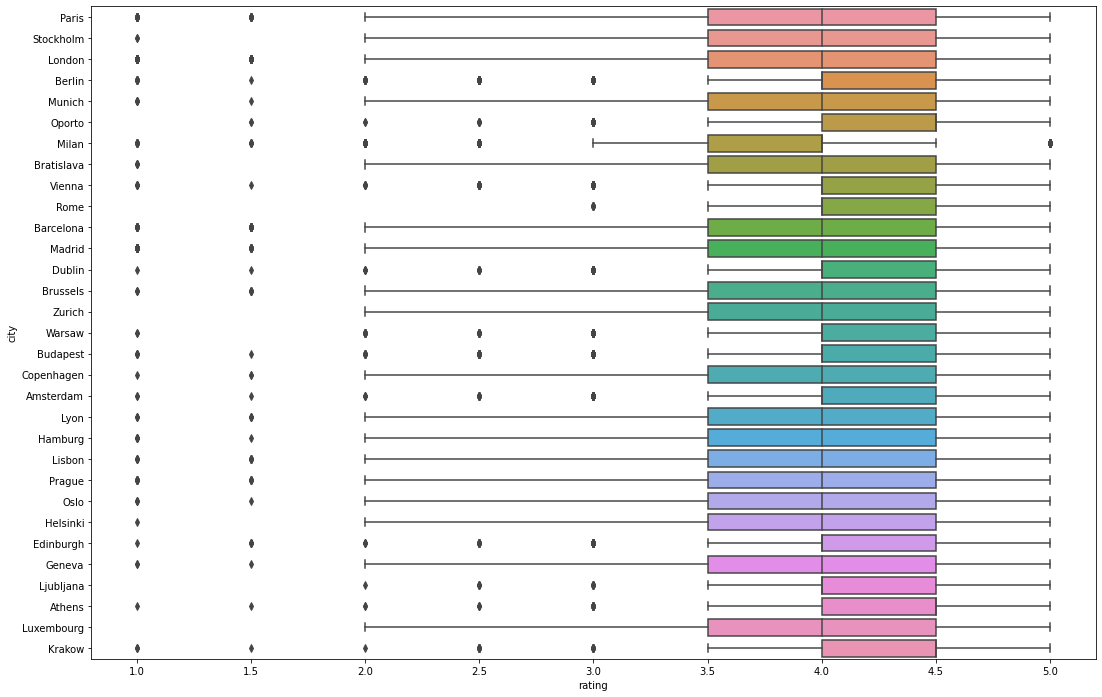

In [65]:
plt.figure(figsize=(18, 12))
sns.boxplot(x='rating', y='city', data=data[data['sample'] != 0]);

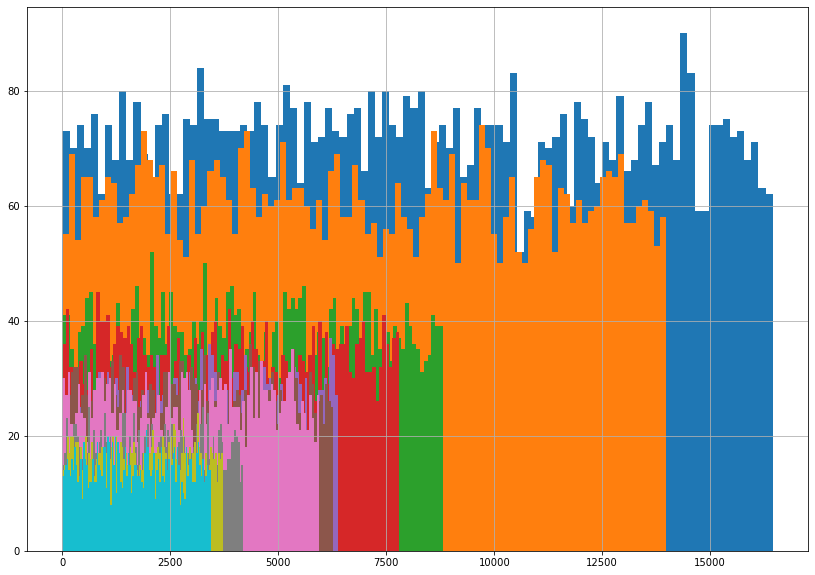

In [66]:
plt.rcParams['figure.figsize'] = (14,10)

# посмотрим на топ 10 городов
for x in (data['city'].value_counts())[0:10].index:
    data['ranking'][data['city'] == x].hist(bins=100)
plt.show()

## Создание dummy-признаков

In [67]:
data.drop(['restaurant_id', 'cuisine_style', 'reviews', 'url_ta', 'id_ta'], axis=1, inplace=True)

In [68]:
# ОДин из вариантов применения OneHotEncoder
# from sklearn.preprocessing import OneHotEncoder
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_city = pd.DataFrame(OH_encoder.fit_transform(df[['city']]))

# Adding column names to the encoded data set.
# OH_city.columns = OH_encoder.get_feature_names(['city_'])

# Show data
# OH_city.head(2)

In [69]:
# Расширение датафрейма на признаки по списку

categ_col = ['city', 'price_range']
# categ_col = ['city', 'cuisine_style', 'price_range']
_main_categs = data[[_col for _col in list(data.columns) if _col not in categ_col]]
_add_categs = [pd.get_dummies(data[_col], prefix = _col) for _col in categ_col]
data = pd.concat([_main_categs] + _add_categs, axis=1)

### Посмотрим распределение целевой переменной

In [70]:
data[data['sample'] != 0]['rating'].value_counts()

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64

### Посмотрим распределение целевой переменной относительно признака

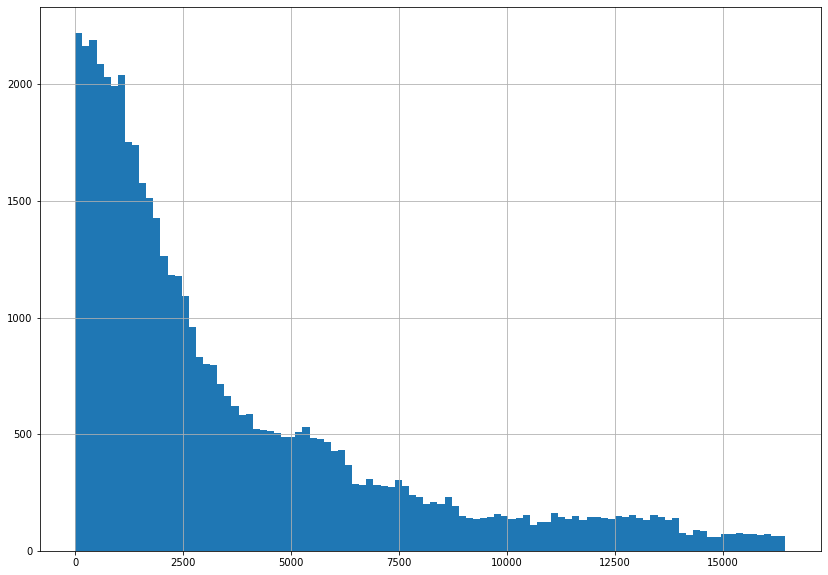

In [71]:
data['ranking'].hist(bins=100)
plt.show()

### [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [72]:
data

,ranking,number_of_reviews,sample,rating,chain,is_capital_city,country_code,population,distance_downtown,review_rank,days_now,days_between_reviews,restaurants_count,ranking_proportion,rests_per_capita,cuisine_count,cuisine_israeli,cuisine_american,cuisine_steakhouse,cuisine_japanese,cuisine_asian,cuisine_pizza,cuisine_diner,cuisine_soups,cuisine_indian,...,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,price_range_1,price_range_2,price_range_3
0,12963.0,4.0,0,0.0,1.0,1,5,2190327,2.392568,0.0,691.0,0.0,6108,2.122299,0.002789,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,106.0,97.0,0,0.0,1.0,1,4,643272,19.203177,0.0,1172.0,37.0,475,0.223158,0.000738,5,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,810.0,28.0,0,0.0,1.0,1,16,488100,1.962467,0.0,1141.0,22.0,745,1.087248,0.001526,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1669.0,202.0,0,0.0,1.0,1,22,8908081,1.167223,-1.0,1159.0,14.0,7193,0.232031,0.000807,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,37.0,162.0,0,0.0,1.0,1,17,432864,1.492694,0.0,1096.0,15.0,380,0.097368,0.000878,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,79.0,1,4.5,1.0,0,10,1378689,0.906784,0.0,1159.0,34.0,2694,0.185598,0.001954,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
49996,6341.0,295.0,1,3.5,1.0,1,5,2190327,0.681281,-1.0,1142.0,9.0,6108,1.038147,0.002789,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
49997,1652.0,4.0,1,4.5,1.0,1,20,961609,0.000000,1.0,1883.0,300.0,1033,1.599226,0.001074,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
49998,641.0,70.0,1,4.0,1.0,1,14,1758143,1.987243,0.0,1312.0,23.0,925,0.692973,0.000526,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [73]:
# после тестирования модели можно удалить признаки, которые не влияли на результат

# lst_drop = ['ranking_proportion', 'number_of_reviews', 'city_Rome', 'ranking',
#             'days_between_reviews', 'days_now', 'distance_downtown', 'population',
#             'cuisine_count', 'city_Madrid', 'restaurants_count', 'review_rank',
#             'city_Amsterdam', 'cuisine_mediterranean', 'cuisine_other'] + ['rating', 'sample']

# for _col in data.columns:
#     if _col not in lst_drop:
#         data.drop(_col, axis=1, inplace=True)

# Применение метода привело к ухудшению результата с 0.1755 до 0,1798

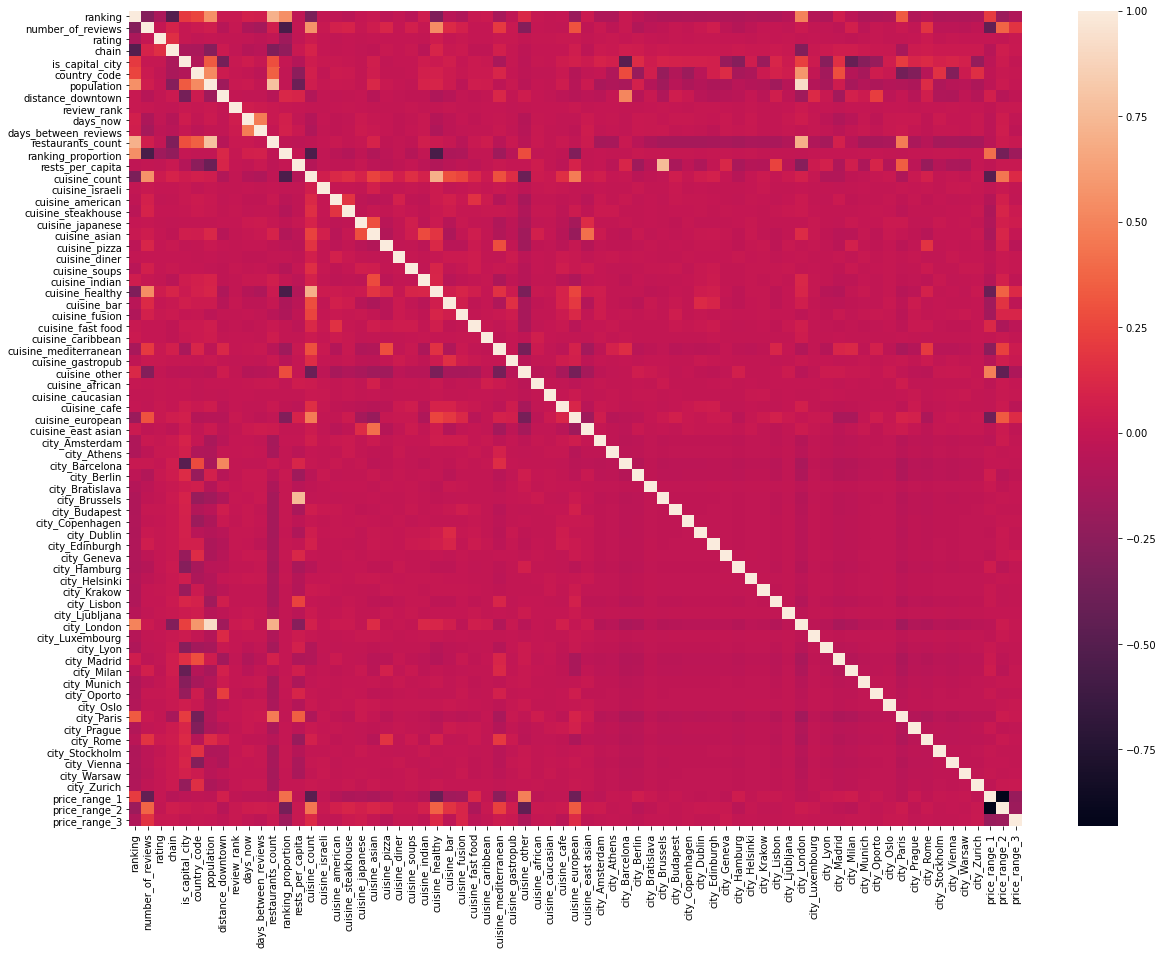

In [74]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(data.drop(['sample'], axis=1).corr())
plt.show()

In [75]:
_matrix = data.drop(['sample'], axis=1).corr()

# Chek the determinant of matrix X (via eginvalues)
evals, evec = np.linalg.eig(_matrix)
ev_product = np.prod(evals) # product of evalues same as determinant
print(f'Rank of Matrix: {np.linalg.matrix_rank(_matrix)}')
print(f'Determinat of matrix :{ev_product}')
print(f'Shape of matrix :{np.shape(_matrix)}')

Rank of Matrix: 71
Determinat of matrix :1.2669263179056438e-90
Shape of matrix :(71, 71)


Ранг матрицы равен ее размерности, но определитель матрицы корреляция имеет 0 значение - в дальнейшем потребуется обработка для устранения мультиколлениарности

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [76]:
# на всякий случай, заново подгружаем данные
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
# df_train['sample'] = 1 # помечаем где у нас трейн
# df_test['sample'] = 0 # помечаем где у нас тест
# df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
# data.info()

In [77]:
#def preproc_data(df_input):
#    includes several functions to pre-process the predictor data.'''
    
#    return df_output

По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП).

#### Запускаем и проверяем что получилось

In [78]:
#df_preproc = preproc_data(data)
#df_preproc.sample(10)

In [79]:
#df_preproc.info()

In [80]:
# Теперь выделим тестовую часть
train_data = data[data['sample'] == 1].drop(['sample'], axis=1)
test_data = data[data['sample'] == 0].drop(['sample'], axis=1)

y = train_data.rating.values
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [81]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [82]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 71), (40000, 71), (40000, 70), (32000, 70), (8000, 70))

# Model 
Сам ML

In [83]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [84]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [85]:
# Напишем функцию корректировки предсказанных рейтингов, так как реальные рейтинги всегда кратны 0.5

def round_rating_pred(_r):
    if _r <= 0.5:
        return 0.0
    if _r <= 1.5:
        return 1.0
    if _r <= 1.75:
        return 1.5
    if _r <= 2.25:
        return 2.0
    if _r <= 2.75:
        return 2.5
    if _r <= 3.25:
        return 3.0
    if _r <= 3.75:
        return 3.5
    if _r <= 4.25:
        return 4.0
    if _r <= 4.75:
        return 4.5
    return 5.0

In [86]:
# Применим такое округление
for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [87]:
y_pred

array([4.5, 4.5, 4.5, ..., 4.5, 4. , 4. ])

In [88]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1744375


In [89]:
# MAE: 0.1744375

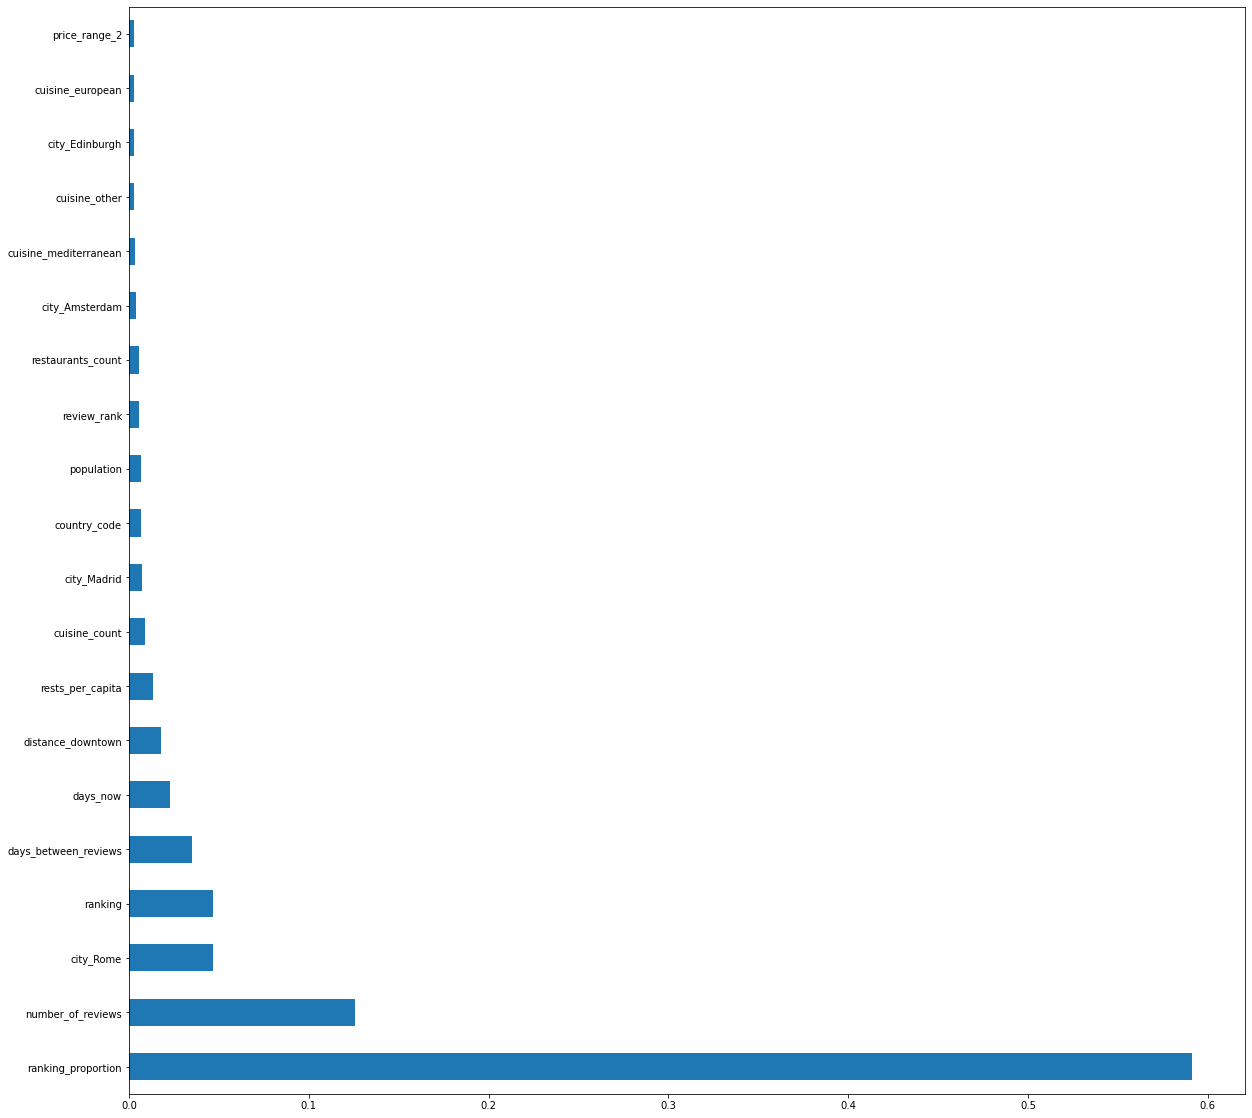

In [90]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (20,20)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [91]:
feat_importances.nlargest(20).index.to_list()

['ranking_proportion',
 'number_of_reviews',
 'city_Rome',
 'ranking',
 'days_between_reviews',
 'days_now',
 'distance_downtown',
 'rests_per_capita',
 'cuisine_count',
 'city_Madrid',
 'country_code',
 'population',
 'review_rank',
 'restaurants_count',
 'city_Amsterdam',
 'cuisine_mediterranean',
 'cuisine_other',
 'city_Edinburgh',
 'cuisine_european',
 'price_range_2']

# Submission
готовим Submission на кагл

In [92]:
test_data.sample(5)

,ranking,number_of_reviews,rating,chain,is_capital_city,country_code,population,distance_downtown,review_rank,days_now,days_between_reviews,restaurants_count,ranking_proportion,rests_per_capita,cuisine_count,cuisine_israeli,cuisine_american,cuisine_steakhouse,cuisine_japanese,cuisine_asian,cuisine_pizza,cuisine_diner,cuisine_soups,cuisine_indian,cuisine_healthy,...,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,price_range_1,price_range_2,price_range_3
2615,14186.0,32.0,0.0,1.0,1,22,8908081,9.421048,0.0,1208.0,81.0,7193,1.972195,0.000807,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3201,1405.0,3.0,0.0,1.0,0,6,1841179,0.562390,0.0,1359.0,0.0,1186,1.184654,0.000644,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5196,1307.0,45.0,0.0,1.0,0,6,1841179,0.000000,0.0,691.0,0.0,1186,1.102024,0.000644,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7733,253.0,228.0,0.0,1.0,1,15,505526,23.573784,-1.0,1082.0,11.0,1647,0.153613,0.003258,4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3964,11484.0,3.0,0.0,1.0,1,22,8908081,0.000000,1.0,1258.0,131.0,7193,1.596552,0.000807,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [93]:
test_data = test_data.drop(['rating'], axis=1)

In [94]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [95]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [96]:
# Применим округление
for i in range(len(predict_submission)):
    predict_submission[i] = round_rating_pred(predict_submission[i])

In [97]:
display(predict_submission)

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [98]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv(os.getcwd() + '/kaggle/output/submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.0
8,id_8,4.0
9,id_9,4.5
